# Locating the occupied lanelets using GeoScenario Library

In [25]:
# add GeoScenarioserver repo directory to path
import sys
sys.path.append("/home/jinwei/workspace/geoscenarioserver/")

from mapping.LaneletMap import LaneletMap

# import lanelet2 related objects
import numpy as np
import lanelet2
from lanelet2.projection import LocalCartesianProjector
from lanelet2.io import Origin
from lanelet2.core import GPSPoint, BasicPoint3d
from lanelet2.geometry import length2d

In [3]:
MapObject = LaneletMap()
projector = LocalCartesianProjector(Origin(0,0))
# MapObject.load_lanelet_map('/home/jinwei/workspace/geoscenarioserver/scenarios/maps/interaction_maps/DR_Roundabout_RW.osm', projector)
MapObject.load_lanelet_map('/home/jinwei/workspace/geoscenarioserver/scenarios/maps/interaction_maps_EXT/DR_USA_Intersection_GL_EXT.osm', projector)

I1003 01:48:48.182351 43842 LaneletMap.py:41] Setting circular references for RightOfWay 50009
I1003 01:48:48.183480 43842 LaneletMap.py:41] Setting circular references for RightOfWay 50008
I1003 01:48:48.183802 43842 LaneletMap.py:41] Setting circular references for RightOfWay 50007
I1003 01:48:48.184119 43842 LaneletMap.py:41] Setting circular references for RightOfWay 50006
I1003 01:48:48.184458 43842 LaneletMap.py:41] Setting circular references for RightOfWay 50005
I1003 01:48:48.184735 43842 LaneletMap.py:41] Setting circular references for RightOfWay 50004
I1003 01:48:48.185042 43842 LaneletMap.py:41] Setting circular references for RightOfWay 50003
I1003 01:48:48.185519 43842 LaneletMap.py:41] Setting circular references for RightOfWay 50002
I1003 01:48:48.185959 43842 LaneletMap.py:41] Setting circular references for RightOfWay 50001


In [4]:
def get_fixed_destination(map_object, x, y, tolerance=0.2):

    bb_list = [[x-tolerance, y-tolerance], [x-tolerance, y+tolerance], [x+tolerance, y+tolerance], [x+tolerance, y-tolerance]]
    for bb in bb_list:
        occupied_lanelets = map_object.get_all_occupying_lanelets(bb[0], bb[1])
        if len(occupied_lanelets) > 0:
            return bb[0], bb[1]
    return None

In [8]:
# # example 1.1; only be occupied by Lanelet 30014;
# lat = 0.009202
# lon = 0.0089362

# # example 1.2; only be occupied by Lanelet 30013 and 30014;
# lat = 0.0091758
# lon = 0.008934

# # example 1.3; little triangle area with no lanelet occupied.
# lat = 0.0090830
# lon = 0.0087459

lat = 0.0089658
lon = 0.0088627

ele = 0
utm_point = projector.forward(GPSPoint(lat, lon, ele))
print(utm_point.x, utm_point.y)
occupied_lanelets = MapObject.get_all_occupying_lanelets(utm_point.x, utm_point.y)
print([ll.id for ll in occupied_lanelets])

986.5912351208067 991.3868381965174
[30019, 30067, 30059, 30042]


In [9]:
# create a routing graph
traffic_rules = lanelet2.traffic_rules.create(lanelet2.traffic_rules.Locations.Germany,
                                                lanelet2.traffic_rules.Participants.Vehicle)
graph = lanelet2.routing.RoutingGraph(MapObject.lanelet_map, traffic_rules)

In [7]:
# temporarily set the current lanelet as the first occupied lanelet
current_lanelet = occupied_lanelets[0]
reachable_lanelet_list = graph.reachableSet(current_lanelet, 1000, 0)
long_ll_list = []
for lanelet in reachable_lanelet_list:
    if length2d(lanelet) > 50:
        long_ll_list.append(lanelet)

# temporary set the first lanelet as the chosen destination one.
assert len(long_ll_list) > 0
final_lanelet = long_ll_list[0]
print(final_lanelet.id)

# validate that there is a path from the current lanelet to the destination
route = graph.getRoute(current_lanelet, final_lanelet)
assert type(route) != None

# get the final point of the center line of the destination lanelet
x = final_lanelet.centerline[-1].x
y = final_lanelet.centerline[-1].y
z = 0
# validate that the final point is in the destination lanelet
# Sometimes the final point is at the edge of the lanelet, and it would be counted outside of the lanelet as the type of float.
final_x, final_y = get_fixed_destination(MapObject, x, y)
print(final_x, final_y)
print("The lon/lat of the destination point are: " + str(projector.reverse(BasicPoint3d(final_x, final_y, z))))
dest_occupied_lanelets = MapObject.get_all_occupying_lanelets(final_x, final_y)
assert dest_occupied_lanelets[0].id == final_lanelet.id

IndexError: list index out of range

In [10]:
lat = 0.0089658
lon = 0.0088627

ele = 0
utm_point = projector.forward(GPSPoint(lat, lon, ele))
print(utm_point.x, utm_point.y)
occupied_lanelets = MapObject.get_all_occupying_lanelets(utm_point.x, utm_point.y)
print([ll.id for ll in occupied_lanelets])

986.5912351208067 991.3868381965174
[30019, 30067, 30059, 30042]


In [46]:
current_lanelet = occupied_lanelets[1]

def get_lanelet_heading_angle(lanelet, x, y):
    centerline_x = [pt.x for pt in lanelet.centerline]
    centerline_y = [pt.y for pt in lanelet.centerline]
    # find the closest point on the centerline to the occupied point
    closest_centerline_index = int(np.argmin(np.linalg.norm(np.array([centerline_x, centerline_y]).T - np.array([utm_point.x, utm_point.y]), axis=1)))
    # get the yaw angle of the current lanelet at the closest point in the unit of degree
    assert len(centerline_x) == len(centerline_y) and len(centerline_x) > 1
    if closest_centerline_index == 0:
        yaw = np.arctan2(centerline_y[1]-centerline_y[0], centerline_x[1]-centerline_x[0])
    elif closest_centerline_index == len(centerline_x)-1:
        yaw = np.arctan2(centerline_y[-1]-centerline_y[-2], centerline_x[-1]-centerline_x[-2])
    else:
        yaw = np.arctan2(centerline_y[closest_centerline_index+1]-centerline_y[closest_centerline_index-1], centerline_x[closest_centerline_index+1]-centerline_x[closest_centerline_index-1])
    yaw = -1* yaw * 180 / np.pi
    print(yaw)

124.82837136709264


In [44]:
np.arctan2(1,1)

0.7853981633974483

9


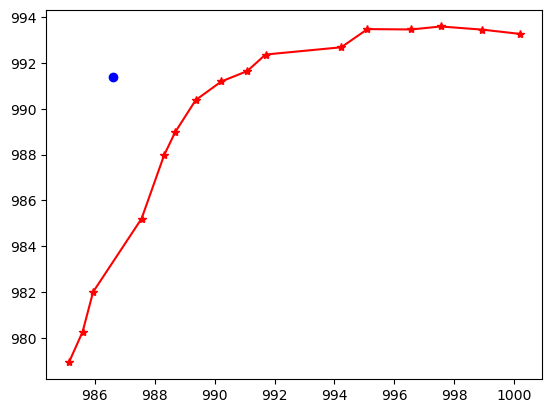

In [30]:
import matplotlib.pyplot as plt
plt.plot(centerline_x, centerline_y, 'r-*')
plt.plot(utm_point.x, utm_point.y, 'bo')
print(closest_centerline_index)